In [1]:
# Import dataset
import pandas as pd
url = 'https://raw.githubusercontent.com/enhatl/ML-Semester-Proj/main/dataset.csv'
df = pd.read_csv(url,index_col=0)

# Decision Tree

In [2]:
# Imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.calibration import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

Data Preprocessing

In [3]:
df_dt = df.copy() #make copy so that we can prepare the data correctly
df_dt = df_dt.dropna(axis = 0) #remove na values

In [4]:
#unique variable, will not be useful to us
df_dt = df_dt.drop('track_id', axis=1)
#album name and track name are not going to be useful either
df_dt = df_dt.drop(['album_name','track_name'], axis=1)

In [5]:
#artist name can be useful, but need to get them as numerical values

label_encoder = LabelEncoder()

#We are assuming the first artist is the main artist and will give the most information.
df_dt['artist_encoded'] = df_dt['artists'].str.split(',').str[0].str.strip()  #Extract first artist
df_dt['artist_encoded'] = label_encoder.fit_transform(df_dt['artist_encoded'])  #Apply label encoding
X = df_dt.drop(['track_genre', 'artists'], axis=1) #dont need artists column anymore
y = df_dt['track_genre']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [7]:
tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [8]:
y_pred = tree_classifier.predict(X_test)

classificationreport=classification_report(y_pred,y_test)
print(classificationreport)

                   precision    recall  f1-score   support

         acoustic       0.09      0.09      0.09       110
         afrobeat       0.28      0.25      0.26       114
         alt-rock       0.03      0.01      0.02       218
      alternative       0.06      0.06      0.06       126
          ambient       0.21      0.23      0.22       105
            anime       0.20      0.15      0.17       127
      black-metal       0.61      0.48      0.54       122
        bluegrass       0.29      0.31      0.30        90
            blues       0.12      0.09      0.10       136
           brazil       0.08      0.04      0.06       183
        breakbeat       0.26      0.32      0.28        91
          british       0.05      0.05      0.05       111
         cantopop       0.25      0.27      0.26        93
    chicago-house       0.45      0.49      0.47        98
         children       0.30      0.32      0.31        82
            chill       0.16      0.15      0.16       

In [9]:
accuracy =accuracy_score(y_pred,y_test)           # calculating accuracy
accuracy

0.23289473684210527

We want to improve that base accuracy. Lets try grid search for an optimal depth.

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3, 5, 7, 10]}
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_max_depth = grid_search.best_params_['max_depth']

# Use the best hyperparameters to train the pruned tree
pruned_tree = DecisionTreeClassifier(max_depth=best_max_depth)
pruned_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [11]:
y_pred_pruned = pruned_tree.predict(X_test)

accuracy_pruned = accuracy_score(y_test, y_pred_pruned)
confusion_mat_pruned = confusion_matrix(y_test, y_pred_pruned)
classification_rep_pruned = classification_report(y_test, y_pred_pruned)

print(f"Accuracy: {accuracy_pruned}")
print(f"Confusion Matrix:\n{confusion_mat_pruned}")
print(f"Classification Report:\n{classification_rep_pruned}")

Accuracy: 0.20535087719298245
Confusion Matrix:
[[ 0  0  0 ...  0  1  0]
 [ 0 40  0 ...  2  0  0]
 [ 0  0  1 ...  1  0  0]
 ...
 [ 0 26  0 ...  7  0  0]
 [ 0  0  0 ...  0 29  0]
 [ 0  1  0 ...  0  3  1]]
Classification Report:
                   precision    recall  f1-score   support

         acoustic       0.00      0.00      0.00       107
         afrobeat       0.15      0.38      0.21       105
         alt-rock       0.20      0.01      0.02       109
      alternative       0.00      0.00      0.00       108
          ambient       0.19      0.29      0.23       112
            anime       1.00      0.01      0.02        96
      black-metal       0.54      0.52      0.53        96
        bluegrass       0.24      0.41      0.30        98
            blues       0.00      0.00      0.00       102
           brazil       0.00      0.00      0.00        97
        breakbeat       0.37      0.25      0.30       113
          british       0.00      0.00      0.00       115
     

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Accuracy still isn't great. Lets try binning some of our attributes. This has a trade off of some information loss, but having the precise value of some of our attributes isn't neccessary.

Let's bin these variables : popularity, duration_ms, danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, and tempo. We set the bins based on the data description given in the readme file.

In [12]:
#make new dataframe so that we dont mess up the old one
X_new = X.copy()

In [13]:
popularity_bins = [0, 25, 50, 75, 100]
popularity_labels = ['Very Low', 'Low', 'Moderate', 'High']

duration_bins = [0, 180000, 200000, 220000, float('inf')]
duration_labels = ['Short', 'Medium', 'Long', 'Very Long']

danceability_bins = [0, 0.5, 0.7, 0.8, 1.0]
danceability_labels = ['Low', 'Moderate', 'High', 'Very High']

energy_bins = [0, 0.4, 0.6, 0.8, 1.0]
energy_labels = ['Low', 'Moderate', 'High', 'Very High']

loudness_bins = [-float('inf'), -8.0, -6.0, -4.0, 0]
loudness_labels = ['Very Low', 'Low', 'Moderate', 'High']

speechiness_bins = [0, 0.33, 0.66, 1.0]
speechiness_labels = ['Music', 'Mixed', 'Speech']

acousticness_bins = [0, 0.2, 0.4, 0.6, 1.0]
acousticness_labels = ['Low', 'Moderate', 'High', 'Very High']

instrumentalness_bins = [0, 0.2, 0.4, 0.6, 1.0]
instrumentalness_labels = ['Low', 'Moderate', 'High', 'Very High']

liveness_bins = [0, 0.2, 0.4, 0.6, 1.0]
liveness_labels = ['Low', 'Moderate', 'High', 'Very High']

valence_bins = [0, 0.25, 0.5, 0.75, 1.0]
valence_labels = ['Low', 'Moderate', 'High', 'Very High']

tempo_bins = [0, 90, 110, 130, float('inf')]
tempo_labels = ['Very Slow', 'Slow', 'Moderate', 'Fast']

X_new['popularity_bin'] = pd.cut(X_new['popularity'], bins=popularity_bins, labels=popularity_labels)
X_new['duration_bin'] = pd.cut(X_new['duration_ms'], bins=duration_bins, labels=duration_labels)
X_new['danceability_bin'] = pd.cut(X_new['danceability'], bins=danceability_bins, labels=danceability_labels)
X_new['energy_bin'] = pd.cut(X_new['energy'], bins=energy_bins, labels=energy_labels)
X_new['loudness_bin'] = pd.cut(X_new['loudness'], bins=loudness_bins, labels=loudness_labels)
X_new['speechiness_bin'] = pd.cut(X_new['speechiness'], bins=speechiness_bins, labels=speechiness_labels)
X_new['acousticness_bin'] = pd.cut(X_new['acousticness'], bins=acousticness_bins, labels=acousticness_labels)
X_new['instrumentalness_bin'] = pd.cut(X_new['instrumentalness'], bins=instrumentalness_bins, labels=instrumentalness_labels)
X_new['liveness_bin'] = pd.cut(X_new['liveness'], bins=liveness_bins, labels=liveness_labels)
X_new['valence_bin'] = pd.cut(X_new['valence'], bins=valence_bins, labels=valence_labels)
X_new['tempo_bin'] = pd.cut(X_new['tempo'], bins=tempo_bins, labels=tempo_labels)


In [14]:
X_new.drop(['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
            'liveness', 'valence', 'tempo'], axis=1, inplace=True)
#need numerical not categorical data
label_encoder = LabelEncoder()
X_new_encoded = X_new.apply(label_encoder.fit_transform)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_new_encoded, y, test_size=0.2, random_state=42)

param_grid = {'max_depth': [3, 5, 7, 10]}
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_max_depth = grid_search.best_params_['max_depth']

# Use the best hyperparameters to train the pruned tree
pruned_binned_tree = DecisionTreeClassifier(max_depth=best_max_depth)
pruned_binned_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [16]:
y_pred_pruned = pruned_binned_tree.predict(X_test)

accuracy_pruned_binned = accuracy_score(y_test, y_pred_pruned)
confusion_mat_pruned_binned = confusion_matrix(y_test, y_pred_pruned)
classification_rep_pruned_binned = classification_report(y_test, y_pred_pruned)

print(f"Accuracy: {accuracy_pruned_binned}")
print(f"Confusion Matrix:\n{confusion_mat_pruned_binned}")
print(f"Classification Report:\n{classification_rep_pruned_binned}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.1686842105263158
Confusion Matrix:
[[14  0  0 ...  0  0  0]
 [ 0  2  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  1  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 2  0  0 ...  0  0  0]]
Classification Report:
                   precision    recall  f1-score   support

         acoustic       0.14      0.07      0.09       213
         afrobeat       0.40      0.01      0.02       203
         alt-rock       0.00      0.00      0.00       215
      alternative       0.07      0.07      0.07       184
          ambient       0.25      0.41      0.31       197
            anime       0.06      0.05      0.06       193
      black-metal       0.20      0.51      0.28       210
        bluegrass       0.09      0.18      0.12       205
            blues       0.19      0.03      0.05       214
           brazil       0.00      0.00      0.00       197
        breakbeat       0.12      0.08      0.09       199
          british       0.22      0.02      0.04       214
      

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Even after binning and re-prunning our tree, we still are stuck at below 25% accuracy. Since we have seemingly exhausted our options for improving our tree, we can safely assume that decision tree is not a great algorithm for our goal. Alternatively, maybe our data just is not capable of making a good prediction overall.

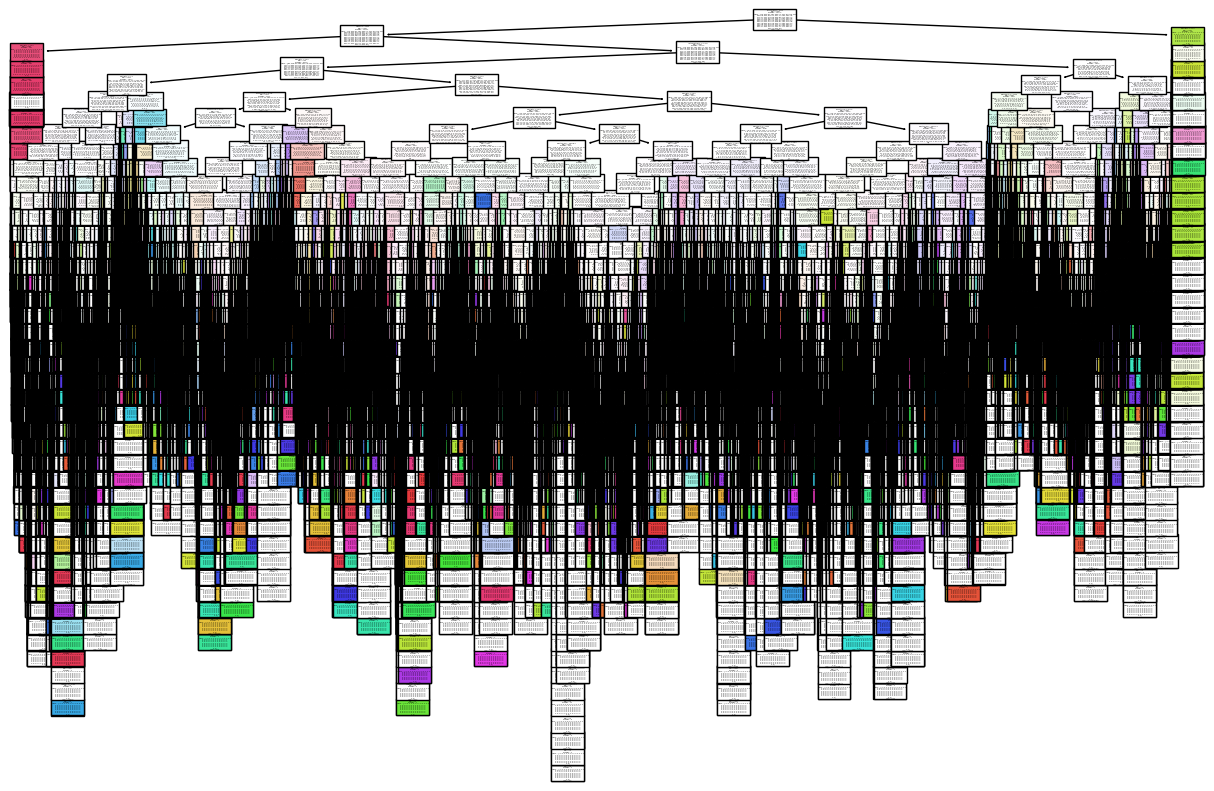

In [18]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names = list(X.columns)

plt.figure(figsize=(15, 10))
plot_tree(tree_classifier, filled=True, feature_names=feature_names, class_names=list(map(str, tree_classifier.classes_)))
plt.show()

# Naive Bayes

In [5]:
df_nb = df.copy()
df_nb = df_nb.dropna(axis = 0) #remove na values

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
df_nb = df_nb.drop('track_id', axis=1)
df_nb = df_nb.drop(['album_name','track_name'], axis=1)
label_encoder = LabelEncoder()
df_nb['artist_encoded'] = df_nb['artists'].str.split(',').str[0].str.strip()
df_nb['artist_encoded'] = label_encoder.fit_transform(df_nb['artist_encoded'])
X= df_nb.drop(['track_genre', 'artists'], axis=1)
y = df_nb['track_genre']
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size = 0.1, random_state = 0)
classifier = GaussianNB()
classifier.fit(X_Train, Y_Train)
y_pred = classifier.predict(X_Test)
accuracy = accuracy_score(Y_Test, y_pred)
confusion_mat = confusion_matrix(Y_Test, y_pred)
classification_rep = classification_report(Y_Test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{confusion_mat}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.11517543859649122
Confusion Matrix:
[[ 3  0  0 ...  0  1  0]
 [ 0  4  0 ...  0  2  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  3  0 ...  0  2  1]
 [ 1  0  0 ...  0 10  0]
 [ 1  0  0 ...  0  2  0]]
Classification Report:
                   precision    recall  f1-score   support

         acoustic       0.12      0.03      0.05       107
         afrobeat       0.16      0.04      0.06       105
         alt-rock       1.00      0.01      0.02       109
      alternative       0.00      0.00      0.00       108
          ambient       0.31      0.14      0.20       112
            anime       0.00      0.00      0.00        96
      black-metal       0.17      0.12      0.14        96
        bluegrass       0.08      0.09      0.09        98
            blues       0.00      0.00      0.00       102
           brazil       0.07      0.01      0.02        97
        breakbeat       0.12      0.03      0.04       113
          british       0.00      0.00      0.00       115
     

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

# Logistic Regression

In [8]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LogisticRegression

df_lr = df.copy()
df_lr = df_lr.dropna(axis=0)
df_lr = df_lr.drop(['track_id', 'album_name', 'track_name'], axis=1)

# Encode the 'artists' column
label_encoder = LabelEncoder()
df_lr['artist_encoded'] = df_lr['artists'].str.split(',').str[0].str.strip()
df_lr['artist_encoded'] = label_encoder.fit_transform(df_lr['artist_encoded'])

# Drop irrelevant columns
X_lr = df_lr.drop(['track_genre', 'artists'], axis=1)
y_lr = df_lr['track_genre']

# Split the data into training and testing sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.1, random_state=0)

# Standardize the features if needed (Logistic Regression is not sensitive to feature scaling, but it might help in some cases)
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)

# Create a Logistic Regression classifier
lr_classifier = LogisticRegression(max_iter= 1000, random_state=0)

# Train the classifier
lr_classifier.fit(X_train_lr, y_train_lr)

# Make predictions on the test set
y_pred_lr = lr_classifier.predict(X_test_lr)

# Evaluate the Logistic Regression model
accuracy_lr = accuracy_score(y_test_lr, y_pred_lr)
confusion_mat_lr = confusion_matrix(y_test_lr, y_pred_lr)
classification_rep_lr = classification_report(y_test_lr, y_pred_lr)

# Print the results
print(f"Accuracy (Logistic Regression): {accuracy_lr}")
print(f"Confusion Matrix (Logistic Regression):\n{confusion_mat_lr}")
print(f"Classification Report (Logistic Regression):\n{classification_rep_lr}")


Accuracy (Logistic Regression): 0.20543859649122806
Confusion Matrix (Logistic Regression):
[[16  0  0 ...  0  0  2]
 [ 0 18  0 ...  2  0  0]
 [ 1  0  0 ...  0  0  3]
 ...
 [ 1  3  0 ... 11  0  1]
 [ 0  0  0 ...  0  3  1]
 [ 3  0  0 ...  0  1 29]]
Classification Report (Logistic Regression):
                   precision    recall  f1-score   support

         acoustic       0.15      0.15      0.15       107
         afrobeat       0.29      0.17      0.22       105
         alt-rock       0.00      0.00      0.00       109
      alternative       0.09      0.02      0.03       108
          ambient       0.27      0.29      0.28       112
            anime       0.06      0.03      0.04        96
      black-metal       0.41      0.52      0.46        96
        bluegrass       0.19      0.19      0.19        98
            blues       0.00      0.00      0.00       102
           brazil       0.10      0.02      0.03        97
        breakbeat       0.23      0.17      0.19       11

# Support Vector Machine

In [5]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

df_svm = df.copy()
df_svm = df_svm.dropna(axis=0)
df_svm = df_svm.drop(['track_id', 'album_name', 'track_name'], axis=1)

# Encode the 'artists' column
label_encoder = LabelEncoder()
df_svm['artist_encoded'] = df_svm['artists'].str.split(',').str[0].str.strip()
df_svm['artist_encoded'] = label_encoder.fit_transform(df_svm['artist_encoded'])

# Drop irrelevant columns
X_svm = df_svm.drop(['track_genre', 'artists'], axis=1)
y_svm = df_svm['track_genre']

# Split the data into training and testing sets
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.1, random_state=0)

# Standardize the features
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
X_test_svm = scaler.transform(X_test_svm)

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', random_state=0)

# Train the classifier
svm_classifier.fit(X_train_svm, y_train_svm)

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test_svm)

# Evaluate the SVM model
accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)
confusion_mat_svm = confusion_matrix(y_test_svm, y_pred_svm)
classification_rep_svm = classification_report(y_test_svm, y_pred_svm)

# Print the results
print(f"Accuracy (SVM): {accuracy_svm}")
print(f"Confusion Matrix (SVM):\n{confusion_mat_svm}")
print(f"Classification Report (SVM):\n{classification_rep_svm}")


Accuracy (SVM): 0.23789473684210527
Confusion Matrix (SVM):
[[25  0  0 ...  0  0  1]
 [ 0 22  0 ...  2  0  0]
 [ 1  0  2 ...  0  0  2]
 ...
 [ 1  3  0 ... 11  0  0]
 [ 3  0  0 ...  0  9  1]
 [ 6  0  0 ...  0  0 29]]
Classification Report (SVM):
                   precision    recall  f1-score   support

         acoustic       0.15      0.23      0.18       107
         afrobeat       0.31      0.21      0.25       105
         alt-rock       0.06      0.02      0.03       109
      alternative       0.12      0.06      0.08       108
          ambient       0.27      0.32      0.29       112
            anime       0.04      0.04      0.04        96
      black-metal       0.45      0.64      0.52        96
        bluegrass       0.27      0.26      0.26        98
            blues       0.04      0.01      0.02       102
           brazil       0.17      0.05      0.08        97
        breakbeat       0.18      0.17      0.17       113
          british       0.00      0.00      0.

# Multi-Layer Perceptron

In [9]:
from sklearn.neural_network import MLPClassifier

df_mlp = df.copy()
df_mlp = df_mlp.dropna(axis=0)
df_mlp = df_mlp.drop(['track_id', 'album_name', 'track_name'], axis=1)

# Encode the 'artists' column
label_encoder = LabelEncoder()
df_mlp['artist_encoded'] = df_mlp['artists'].str.split(',').str[0].str.strip()
df_mlp['artist_encoded'] = label_encoder.fit_transform(df_mlp['artist_encoded'])

# Drop irrelevant columns
X_mlp = df_mlp.drop(['track_genre', 'artists'], axis=1)
y_mlp = df_mlp['track_genre']

# Split the data into training and testing sets
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_mlp, y_mlp, test_size=0.1, random_state=0)

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train_mlp = scaler.fit_transform(X_train_mlp)
X_test_mlp = scaler.transform(X_test_mlp)

# Create an MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=0)

# Train the classifier
mlp_classifier.fit(X_train_mlp, y_train_mlp)

# Make predictions on the test set
y_pred_mlp = mlp_classifier.predict(X_test_mlp)

# Evaluate the MLP model
accuracy_mlp = accuracy_score(y_test_mlp, y_pred_mlp)
confusion_mat_mlp = confusion_matrix(y_test_mlp, y_pred_mlp)
classification_rep_mlp = classification_report(y_test_mlp, y_pred_mlp)

# Print the results
print(f"Accuracy (MLP): {accuracy_mlp}")
print(f"Confusion Matrix (MLP):\n{confusion_mat_mlp}")
print(f"Classification Report (MLP):\n{classification_rep_mlp}")


Accuracy (MLP): 0.3429824561403509
Confusion Matrix (MLP):
[[15  0  1 ...  1  0  2]
 [ 0 35  0 ...  5  2  0]
 [ 0  0  6 ...  0  1  0]
 ...
 [ 1  6  1 ... 24  0  0]
 [ 0  0  0 ...  3 29  0]
 [ 3  1  2 ...  0  0 28]]
Classification Report (MLP):
                   precision    recall  f1-score   support

         acoustic       0.21      0.14      0.17       107
         afrobeat       0.51      0.33      0.40       105
         alt-rock       0.15      0.06      0.08       109
      alternative       0.15      0.10      0.12       108
          ambient       0.39      0.39      0.39       112
            anime       0.31      0.17      0.22        96
      black-metal       0.54      0.66      0.59        96
        bluegrass       0.40      0.54      0.46        98
            blues       0.17      0.10      0.12       102
           brazil       0.17      0.37      0.24        97
        breakbeat       0.48      0.43      0.45       113
          british       0.19      0.05      0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.